In [ ]:
# ================================================================
# 01_preprocess.py  –  Pré-processamento diário (versão peso em gramas)
# ------------------------------------------------------------
# Este script lê o arquivo Excel `datasets/dados.xlsx`, aplica
# validações robustas, trata outliers e gera os 15 indicadores
# diários exigidos pelo projeto. Agora o peso é convertido de kg
# para gramas (`peso_g`). As razões por kg continuam corretas ao
# dividir `peso_g` por 1 000.
# ------------------------------------------------------------
# Como usar (terminal macOS, já com venv ativo):
#   python src/01_preprocess.py
# ------------------------------------------------------------
# Requisitos: pandas, numpy, pyarrow, openpyxl, tqdm (opcional)
# Instalação sugerida (brew + pip):
#   brew install pyarrow
#   pip install pandas numpy openpyxl tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Configurações básicas
# -----------------------------------------------------------------

DATA_PATH = Path("datasets") / "dados.xlsx"  # input
OUTPUT_PATH = Path("datasets") / "dados_diarios_preproc.parquet"  # output

# Colunas mínimas que o pipeline não pode rodar sem
REQUIRED_COLS = {
    "data", "peso_kg",
    "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade",
    "passos", "minutos_em_pe",
    "fc_repouso_bpm", "hrv_medio",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Colunas que não podem ter valores negativos
NON_NEGATIVE = {
    "peso_kg", "gordura_pct", "massa_magra_pct", "circunferencia_cm",
    "energia_total", "energia_atividade", "passos", "minutos_em_pe",
    "duracao_sono_min", "minutos_deep",
    "calorias_consumidas", "carboidratos_g", "proteinas_g", "agua_consumida_ml",
}

# Quantis usados para winsorização
QUANT_LOW, QUANT_HIGH = 0.05, 0.95

# -----------------------------------------------------------------
# 2. Funções utilitárias
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê o Excel, normaliza nomes de colunas e remove duplicatas.

    - `strip()` espaços iniciais/finais
    - converte a `snake_case` mínima (lower)
    - se nomes repetirem, mantém somente a primeira ocorrência
    """
    df = pd.read_excel(path, engine="openpyxl")

    # normaliza cabeçalhos
    new_cols = []
    seen = set()
    for raw in df.columns:
        col = str(raw).strip()
        col = col.replace(" ", "_").lower()
        if col in seen:
            warnings.warn(
                f"Coluna duplicada encontrada e ignorada: '{col}'. Somente a primeira ocorrência será usada.",
                RuntimeWarning,
            )
            continue
        new_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = new_cols
    return df


def winsorize(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Aplica winsorização p5–p95 inplace para as colunas fornecidas."""
    for col in tqdm(cols, desc="Winsorizando", leave=False):
        lo, hi = df[col].quantile([QUANT_LOW, QUANT_HIGH], interpolation="linear")
        df[col] = df[col].clip(lo, hi)
    return df

# -----------------------------------------------------------------
# 3. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not DATA_PATH.exists():
        sys.exit(f"❌ Arquivo de dados não encontrado em {DATA_PATH.resolve()}")

    print("📥  Lendo planilha…")
    df = read_excel_unique(DATA_PATH)

    # ----- validação de colunas essenciais -----
    missing = sorted(REQUIRED_COLS - set(df.columns))
    if missing:
        sys.exit(f"❌ Faltando colunas obrigatórias: {missing}")

    # ----- normalização de tipos & valores impossíveis -----
    print("🧹  Ajustando tipos e valores…")
    df["data"] = pd.to_datetime(df["data"], errors="coerce")

    for col in NON_NEGATIVE & set(df.columns):
        df.loc[df[col] < 0, col] = np.nan

    # ----- converte peso para gramas e remove peso_kg -----
    df["peso_g"] = df["peso_kg"] * 1000.0  # precisão em gramas
    df.drop(columns="peso_kg", inplace=True)

    # ----- winsorização p5–p95 -----
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    winsorize(df, numeric_cols)

    # -----------------------------------------------------------------
    # 4. Cálculo dos indicadores
    # -----------------------------------------------------------------
    print("🧮  Calculando indicadores…")

    df_ind = pd.DataFrame()
    df_ind["data"] = df["data"]

    # cópias diretas
    df_ind["Fat_pct_mean"]          = df["gordura_pct"]
    df_ind["Circumference_cm_med"] = df["circunferencia_cm"]
    df_ind["Total_kcal_mean"]       = df["energia_total"]
    df_ind["Steps_mean"]            = df["passos"]
    df_ind["RestingHR_mean"]        = df["fc_repouso_bpm"]
    df_ind["HRV_mean"]              = df["hrv_medio"]
    df_ind["SleepDur_mean"]         = df["duracao_sono_min"]
    df_ind["Water_ml_mean"]         = df["agua_consumida_ml"]

    # derivadas / razões
    df_ind["Lean_to_Fat_ratio"]       = df["massa_magra_pct"] / df["gordura_pct"]
    df_ind["Activity_kcal_fraction"]  = df["energia_atividade"] / df["energia_total"]
    df_ind["Standing_minutes_raw"]    = df["minutos_em_pe"]  # para desvio-padrão futuro
    df_ind["DeepFrac_mean"]           = df["minutos_deep"] / df["duracao_sono_min"]

    # razões por kg – dividimos peso em gramas por 1000
    kg_denominator = df["peso_g"] / 1000.0
    df_ind["Carb_per_kg_mean"]        = df["carboidratos_g"] / kg_denominator
    df_ind["Protein_per_kg_mean"]     = df["proteinas_g"] / kg_denominator

    # déficit calórico permanece igual
    df_ind["Cal_deficit_mean"]        = df["calorias_consumidas"] - df["energia_total"]

    # ----- salva parquet -----
    print("💾  Gravando Parquet…")
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_ind.sort_values("data").to_parquet(OUTPUT_PATH, index=False, engine="pyarrow")

    # resumo rápido
    print("\n✅  Pré-processamento concluído!")
    print(f"Arquivo salvo em: {OUTPUT_PATH.resolve()}")
    print("\nResumo numérico (pós-winsor):")
    print(df_ind.describe().loc[["mean", "std", "min", "max"]].round(2))


if __name__ == "__main__":
    main()


WIndows cons

In [14]:
# ================================================================
# 02_window_construction.py – Construção das janelas de 91 dias
# ------------------------------------------------------------
# Pipeline comentado linha a linha:
#   1. Lê o parquet diário com 15 indicadores + peso em gramas.
#   2. Anexa o peso (g) para cada dia a partir do Excel.
#   3. Desliza janelas de 91 dias (step = 7).
#   4. Agrega indicadores (média, mediana, desvio‑padrão).
#   5. Calcula o alvo: inclinação da reta peso × tempo (kg/sem).
#   6. Salva o resultado em Parquet para uso no BSTS.
# ------------------------------------------------------------
# Execução (terminal macOS):
#   python src/02_window_construction.py
# ------------------------------------------------------------
# Dependências: pandas, numpy, pyarrow, openpyxl, tqdm
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm

# -----------------------------------------------------------------
# 1. Caminhos e parâmetros
# -----------------------------------------------------------------

DAILY_PARQUET = Path("datasets") / "dados_diarios_preproc.parquet"
EXCEL_SOURCE = Path("datasets") / "dados.xlsx"
WINDOW_PARQUET = Path("datasets") / "janelas_91d.parquet"

WINDOW_SIZE = 91   # dias na janela
STEP_SIZE = 7      # deslocamento

# -----------------------------------------------------------------
# 2. Leitura defensiva do Excel (sem colunas duplicadas)
# -----------------------------------------------------------------

def read_excel_unique(path: Path) -> pd.DataFrame:
    """Lê Excel, normaliza cabeçalhos e descarta colunas duplicadas."""
    df = pd.read_excel(path, engine="openpyxl")

    norm_cols, seen = [], set()
    for raw in df.columns:
        col = str(raw).strip().replace(" ", "_").lower()
        if col in seen:
            warnings.warn(f"Coluna duplicada ignorada: {col}")
            continue
        norm_cols.append(col)
        seen.add(col)

    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.columns = norm_cols
    return df

# -----------------------------------------------------------------
# 3. Funções de agregação por janela
# -----------------------------------------------------------------

def slope_kg_per_week(sub: pd.DataFrame) -> float:
    """Inclinação da reta de peso (kg/semana) dentro de uma janela."""
    y = sub["peso_g"].values / 1000.0  # g → kg
    if np.isnan(y).any():
        return np.nan
    x = np.arange(len(sub))            # 0..90
    slope_day = np.polyfit(x, y, 1)[0] # kg/dia
    return slope_day * 7               # kg/semana


def aggregate_window(sub: pd.DataFrame) -> dict:
    """Calcula métricas da janela (mean, median, std) + alvo."""
    out: dict[str, float] = {}

    # --- médias (11) ---
    mean_cols = {
        "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
        "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
        "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    }
    for c in mean_cols:
        out[c] = sub[c].mean()

    # --- mediana (1) ---
    out["Circumference_cm_med"] = sub["Circumference_cm_med"].median()

    # --- desvio‑padrão (1) ---
    out["Standing_variability"] = sub["Standing_minutes_raw"].std()

    # --- razões por kg (2) ---
    out["Carb_per_kg_mean"]    = sub["Carb_per_kg_mean"].mean()
    out["Protein_per_kg_mean"] = sub["Protein_per_kg_mean"].mean()

    # --- alvo ---
    out["slope_kg_per_week"] = slope_kg_per_week(sub)
    return out


def generate_windows(df: pd.DataFrame) -> pd.DataFrame:
    """Gera DataFrame final: 1 linha por janela deslizante."""
    records = []
    starts = range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE)
    for i in tqdm(starts, desc="Gerando janelas"):
        sub = df.iloc[i : i + WINDOW_SIZE]
        rec = aggregate_window(sub)
        rec["window_start"] = sub["data"].iloc[0]
        records.append(rec)
    return pd.DataFrame(records)

# -----------------------------------------------------------------
# 4. Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    # 4.1 Carrega indicadores diários
    if not DAILY_PARQUET.exists():
        sys.exit("❌ Parquet diário não encontrado. Rode 01_preprocess.py primeiro.")
    df_ind = pd.read_parquet(DAILY_PARQUET)

    # 4.2 Anexa peso (g)
    df_weight = read_excel_unique(EXCEL_SOURCE)[["data", "peso_kg"]]
    df_weight["data"] = pd.to_datetime(df_weight["data"], errors="coerce")
    df_weight["peso_g"] = df_weight["peso_kg"] * 1000.0

    # merge (inner) – remove datas sem indicador ou sem peso
    df_full = (
        df_ind.merge(df_weight[["data", "peso_g"]], on="data", how="inner")
               .sort_values("data")
               .reset_index(drop=True)
    )

    # 4.3 Gera janelas
    df_windows = generate_windows(df_full)

    # 4.4 Salva
    WINDOW_PARQUET.parent.mkdir(parents=True, exist_ok=True)
    df_windows.to_parquet(WINDOW_PARQUET, index=False, engine="pyarrow")

    # 4.5 Resumo
    print("✅  Janelas salvas em:", WINDOW_PARQUET.resolve())
    print("Total de janelas:", len(df_windows))
    print(df_windows.head())


if __name__ == "__main__":
    main()


Gerando janelas: 100%|██████████| 130/130 [00:00<00:00, 3230.94it/s]

✅  Janelas salvas em: /Users/luc/Documents/TCC v2/datasets/janelas_91d.parquet
Total de janelas: 130
   DeepFrac_mean  Water_ml_mean  RestingHR_mean   Steps_mean  SleepDur_mean  \
0       0.300193    2178.089560       62.428571  7723.165934     480.945055   
1       0.300173    2184.254945       62.329670  7671.605495     481.340659   
2       0.300144    2178.802747       62.153846  7712.385714     481.274725   
3       0.300093    2182.385165       62.373626  7870.154945     482.087912   
4       0.300091    2196.855495       62.230769  7917.352747     482.824176   

   Cal_deficit_mean   HRV_mean  Lean_to_Fat_ratio  Total_kcal_mean  \
0       -798.222527  50.674725           3.764655      1995.100549   
1       -803.310989  50.689011           3.761750      1991.165934   
2       -818.147802  50.395604           3.795185      1996.847253   
3       -814.224725  50.383516           3.809480      1997.486264   
4       -802.893407  50.085659           3.826643      1991.507143   

   

Correlação

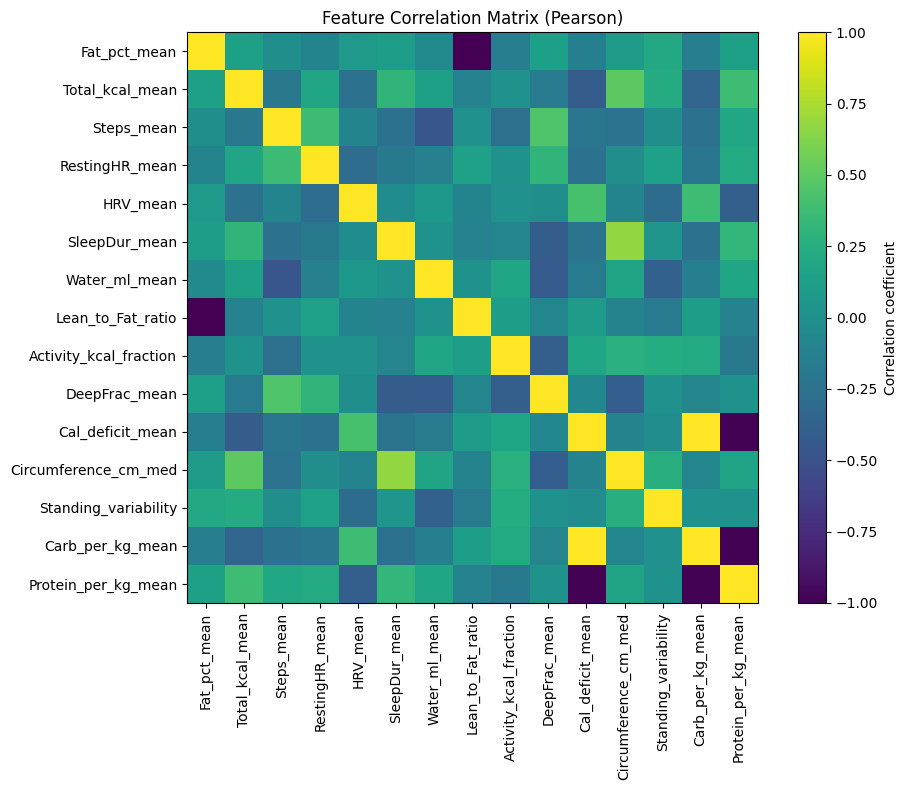

,var1,var2,corr
0,Fat_pct_mean,Lean_to_Fat_ratio,-0.994326
1,Cal_deficit_mean,Carb_per_kg_mean,0.994319
2,Carb_per_kg_mean,Protein_per_kg_mean,-0.988365
3,Cal_deficit_mean,Protein_per_kg_mean,-0.985024


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display

# --- 1. Load the windows data ---
df_windows = pd.read_parquet("datasets/janelas_91d.parquet")

# --- 2. Select feature columns ---
feature_cols = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean"
]
X = df_windows[feature_cols]

# --- 3. Correlation matrix ---
corr_matrix = X.corr()

# --- 4. Heatmap (agora com viridis) ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix.values, vmin=-1, vmax=1, cmap="viridis")  # ← aqui
ax.set_xticks(range(len(feature_cols)))
ax.set_yticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=90)
ax.set_yticklabels(feature_cols)
ax.set_title("Feature Correlation Matrix (Pearson)")
plt.colorbar(im, ax=ax, label="Correlation coefficient")
plt.tight_layout()
plt.show()

# --- 5. Pairs with |corr| ≥ 0.80 ---
threshold = 0.80
rows = [
    {"var1": feature_cols[i], "var2": feature_cols[j], "corr": corr_matrix.iat[i, j]}
    for i, j in combinations(range(len(feature_cols)), 2)
    if abs(corr_matrix.iat[i, j]) >= threshold
]
high_corr_df = (pd.DataFrame(rows)
                .sort_values("corr", key=np.abs, ascending=False)
                .reset_index(drop=True))

display(high_corr_df)


Tratamento da colinearidade

In [21]:
# ================================================================
# 03_collinearity_filter_v2.py – Colinearidade com desempate por |ρ(X, y)|
# ------------------------------------------------------------------------
# - Agrupa variáveis com |ρ| ≥ 0.80 (Pearson) no dataset de janelas.
# - Para cada grupo:
#     1) calcula a média das correlações absolutas de cada coluna com as outras;
#     2) seleciona aquelas com a menor média;
#     3) se houver empate, mantém a de maior |corr(col, slope_kg_per_week)|.
# - Gera listas "mantidas" e "eliminadas" preservando a ordem original.
# - Salva Parquet filtrado + txt de eliminadas.
# ------------------------------------------------------------------------
# Execução:
#   python src/03_collinearity_filter_v2.py
# Dependências: pandas, numpy, pyarrow, networkx
# ================================================================

from __future__ import annotations

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx

# -----------------------------------------------------------------
# Caminhos e parâmetros
# -----------------------------------------------------------------
WINDOW_PARQUET = Path("datasets") / "janelas_91d.parquet"
FILTERED_PARQUET = Path("datasets") / "janelas_91d_filtered.parquet"
REMOVED_TXT = Path("datasets") / "janelas_91d_removed_cols.txt"

THRESHOLD = 0.80  # |ρ| limiar

FEATURE_COLS = [
    "Fat_pct_mean", "Total_kcal_mean", "Steps_mean", "RestingHR_mean",
    "HRV_mean", "SleepDur_mean", "Water_ml_mean", "Lean_to_Fat_ratio",
    "Activity_kcal_fraction", "DeepFrac_mean", "Cal_deficit_mean",
    "Circumference_cm_med", "Standing_variability",
    "Carb_per_kg_mean", "Protein_per_kg_mean",
]

TARGET_COL = "slope_kg_per_week"
DATE_COL = "window_start"

# -----------------------------------------------------------------
# Funções utilitárias
# -----------------------------------------------------------------

def build_graph(corr: pd.DataFrame, cols: list[str], thr: float) -> nx.Graph:
    g = nx.Graph()
    g.add_nodes_from(cols)
    for i, c1 in enumerate(cols):
        for c2 in cols[i + 1 :]:
            if abs(corr.loc[c1, c2]) >= thr:
                g.add_edge(c1, c2)
    return g


def pick_keep_column(group: list[str], corr: pd.DataFrame, y_corr: pd.Series) -> str:
    """Retorna coluna a ser mantida segundo média |ρ|, desempate pelo |ρ| com y."""
    # 1. média |ρ| interna
    mean_r = {
        col: np.mean([abs(corr.loc[col, other]) for other in group if other != col])
        for col in group
    }
    min_mean = min(mean_r.values())
    candidates = [col for col, m in mean_r.items() if np.isclose(m, min_mean)]

    if len(candidates) == 1:
        return candidates[0]

    # 2. desempate pelo |corr(col, y)|
    best = max(candidates, key=lambda c: abs(y_corr[c]))
    return best

# -----------------------------------------------------------------
# Pipeline principal
# -----------------------------------------------------------------

def main() -> None:
    if not WINDOW_PARQUET.exists():
        sys.exit("❌ Arquivo de janelas não encontrado. Rode 02_window_construction.py")

    df = pd.read_parquet(WINDOW_PARQUET)
    X = df[FEATURE_COLS]
    y = df[TARGET_COL]

    corr = X.corr()
    y_corr = X.apply(lambda col: col.corr(y))  # Series |corr(X, y)| para desempate

    graph = build_graph(corr, FEATURE_COLS, THRESHOLD)
    groups = list(nx.connected_components(graph))

    kept, removed_info = [], []
    for grp in groups:
        grp_list = sorted(grp, key=lambda c: FEATURE_COLS.index(c))
        if len(grp_list) == 1:
            kept.append(grp_list[0])
            continue
        keep_col = pick_keep_column(grp_list, corr, y_corr)
        kept.append(keep_col)
        for col in grp_list:
            if col == keep_col:
                continue
            mean_internal = np.mean([abs(corr.loc[col, other]) for other in grp_list if other != col])
            removed_info.append((col, mean_internal))

    kept.sort(key=lambda c: FEATURE_COLS.index(c))
    removed_info.sort(key=lambda t: FEATURE_COLS.index(t[0]))

    # Relatório
    print("Mantidas (", len(kept), "):")
    print(kept)
    print("\nEliminadas (", len(removed_info), ") – média |ρ| interna:")
    for col, m in removed_info:
        print(f"  {col:<25} {m:.3f}")

    # Salva
    df[kept + [TARGET_COL, DATE_COL]].to_parquet(FILTERED_PARQUET, index=False, engine="pyarrow")
    with REMOVED_TXT.open("w") as f:
        for col, m in removed_info:
            f.write(f"{col}\t{m:.3f}\n")

    print("\n✅  Parquet filtrado salvo em:", FILTERED_PARQUET.resolve())
    print("Lista de eliminadas em:", REMOVED_TXT.resolve())


if __name__ == "__main__":
    main()

Mantidas ( 12 ):
['Fat_pct_mean', 'Total_kcal_mean', 'Steps_mean', 'RestingHR_mean', 'HRV_mean', 'SleepDur_mean', 'Water_ml_mean', 'Activity_kcal_fraction', 'DeepFrac_mean', 'Circumference_cm_med', 'Standing_variability', 'Protein_per_kg_mean']

Eliminadas ( 3 ) – média |ρ| interna:
  Lean_to_Fat_ratio         0.994
  Cal_deficit_mean          0.990
  Carb_per_kg_mean          0.991

✅  Parquet filtrado salvo em: /Users/luc/Documents/TCC v2/datasets/janelas_91d_filtered.parquet
Lista de eliminadas em: /Users/luc/Documents/TCC v2/datasets/janelas_91d_removed_cols.txt
